In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch
from matplotlib import animation
import ipywidgets as widgets
from scipy import optimize as opt
from urllib.request import urlopen
from PIL import Image
from io import BytesIO
import scipy.stats as stats
from matplotlib.animation import FuncAnimation
from scipy import special
from scipy.optimize import minimize


# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

### Linear Regression - Ordinary Least Squares (OLS) solution 

Following the lecture, we start with a linear regression on 1D data. 
(as in the lecture, we do not have an offset ($\theta_0=0$))

*First we generate the data with a true theta.*

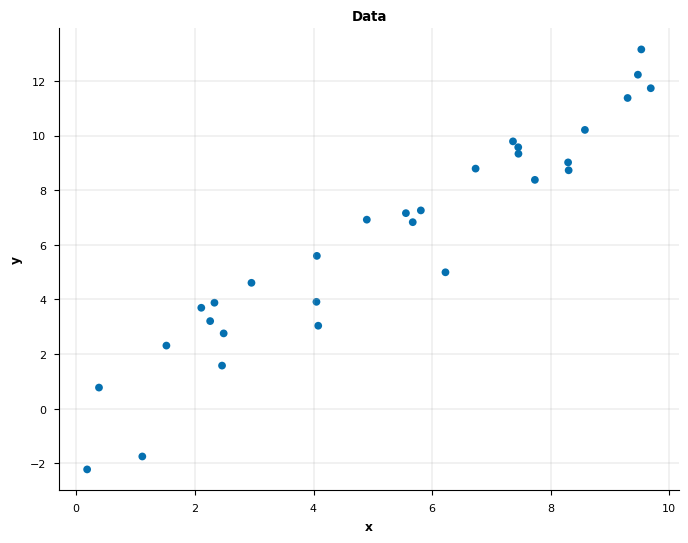

In [2]:
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)[:,None]  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)[:,None]  # sample from a standard normal distribution
y = theta * x + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y', title = 'Data');

As shown in the lecture, the solution for this problem is the same, no matter if we follow the idea of the mean square error (MSE) or the maximum likelihod estimate (MLE):

\begin{aligned}
\theta^*=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \boldsymbol{y}
\end{aligned}

Below we implement this solution in a flexible way so that we can use this function throughout the notebook

In [3]:
def solve_normal_eqn(X, y):
    # Compute theta_hat using OLS
    theta_star = np.linalg.inv(X.T @ X) @ X.T @ y

    return theta_star[:,0]

Given the data we created above, we can now solve for the best fit and plot the result

In [8]:
def solve_normal_equ_and_plot(X,y):

    theta_star = solve_normal_eqn(X, y)
    print (theta_star.shape)
    
    x_plot = X
    if x_plot.shape[1] > 1:
        x_plot = X[:,1]
        
    y_star = np.sum(X*theta_star,axis=1) # we do the sum here so that we can use the same function later on 
    
    
    fig, ax = plt.subplots()
    ax.scatter(x_plot, y, label='Observed')  # our data scatter plot
    ax.plot(x_plot, y_star, color='r', label='Fit')  # our estimated model
    ax.set(
      title=fr"$\theta^*$ ={np.round(theta_star,2)}, MSE = {np.round(np.mean((y - y_star)**2),2)}",
      xlabel='x',
      ylabel='y'
    )
    ax.legend()

(1,)


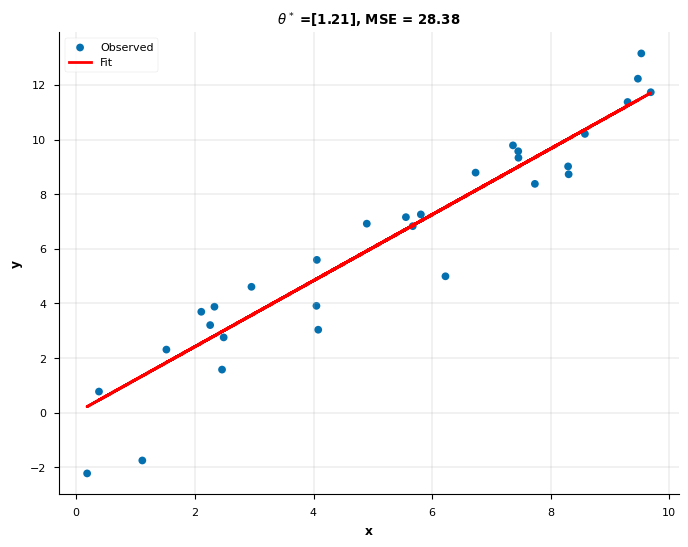

In [9]:
solve_normal_equ_and_plot(x,y)

great! that woorks

## Multiple linear regression - model evaluation


As a first intermediate step towards multiple linear regression, we now introduce an offset and see how the previous model will fail to capture the data and how we can fix this by adjusting the design matrix


Let's generate new data with an offset $\theta_0$

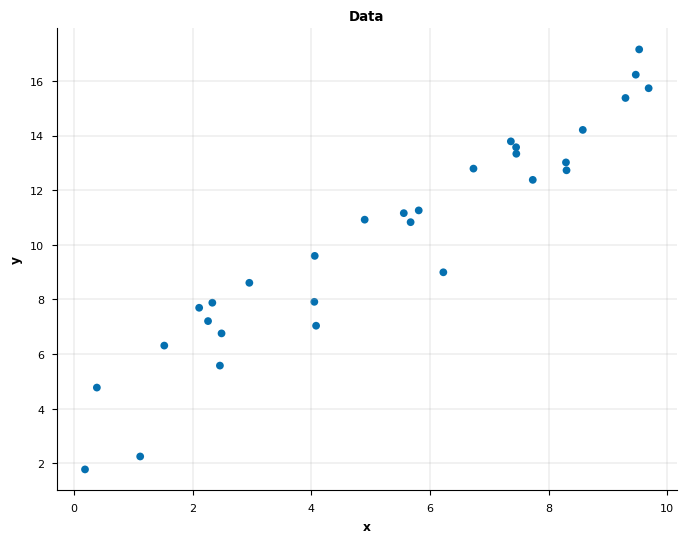

In [10]:
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

theta_0 = 4

# Draw x and then calculate y
x_offset = 10 * np.random.rand(n_samples)[:,None]  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)[:,None]  # sample from a standard normal distribution
y_offset = theta * x_offset + noise + theta_0

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x_offset, y_offset)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y', title = 'Data');

We can use the function we created above to solve for the best theta given the new - offset - data

(1,)


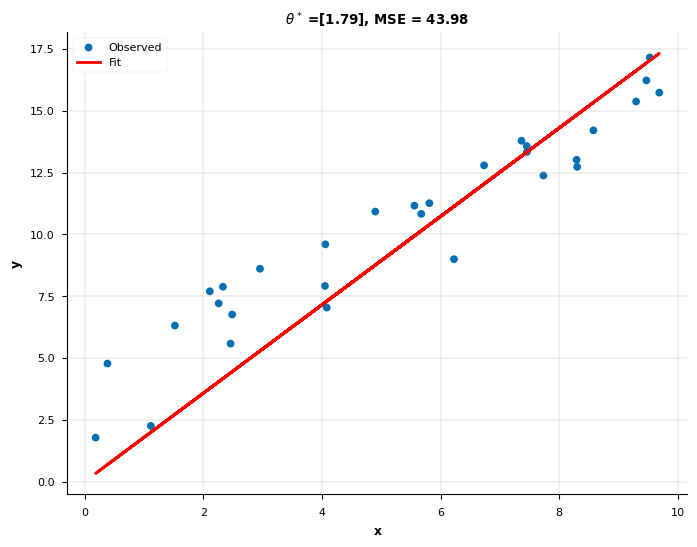

In [11]:
solve_normal_equ_and_plot(x_offset,y_offset)

As we can see, the fit differs quite substantially from the original theta we put in (1.2) since the model cannot account for the offset. As discussed in the lecture, we can fix that by adding a bias ($x_0 = 1$) to the design matrix, i.e to all the samples of our data 

(2,)


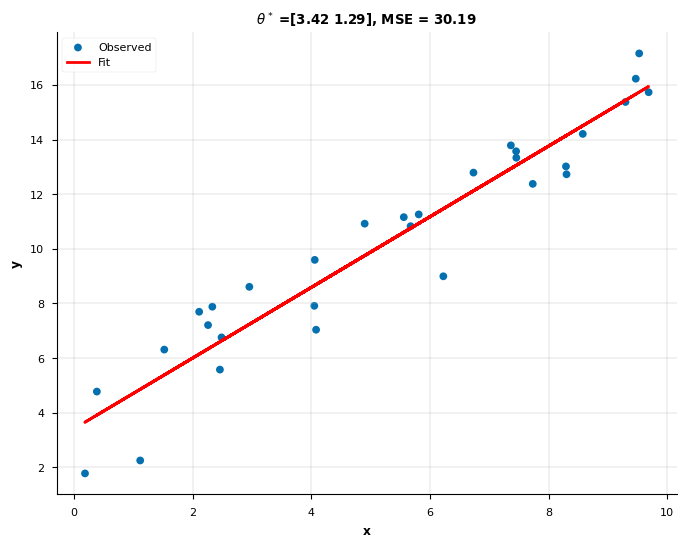

In [12]:
X_design_offset = np.hstack([np.ones_like(x_offset),x_offset])
solve_normal_equ_and_plot(X_design_offset,y_offset)

This works much better!


Now moving towards polynomal regression, we can add $x_2$ as another dimension. For example $x_1$ can describe the orientation of the stimulus, while $x_2$ describes the contrast.

Below, we create such a dataset and visualize it in 3d

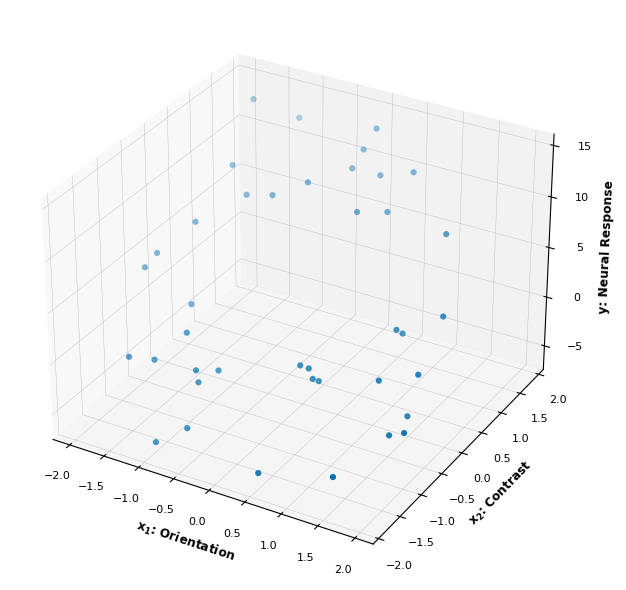

In [18]:
# Set parameters
theta = np.array([4, -1, 5])
n_samples = 40

x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
noise = np.random.randn(n_samples)[:,None]

y_3d = theta[0] + x1 * theta[1] + x2 * theta[2] + noise


ax = plt.subplot(projection='3d')
ax.scatter(x1, x2, y_3d, '.', color='#0570b0')

ax.set(
    xlabel='$\mathbf{x_1}$: Orientation',
    ylabel='$\mathbf{x_2}$: Contrast',
    zlabel='y: Neural Response'
)
plt.tight_layout()

### Task 1

Can you create the proper design matrix that allows you to fit a linear model to the data using the function?



In [44]:

# change the code here and uncomment everything
# design_matrix = ...

# theta_star = solve_normal_eqn(design_matrix, y_3d)


# xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
# y_star_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_star[1:] + theta_star[0]
# y_star_grid = y_star_grid.reshape((50, 50))

# ax = plt.subplot(projection='3d')
# ax.scatter(x1, x2, y_3d, '.', color='#0570b0')
# ax.plot_surface(xx, yy, y_star_grid, linewidth=0, alpha=0.5, color='C1',
#                 cmap=plt.get_cmap('coolwarm'))
# ax.set(
#     xlabel='$\mathbf{x_1}$: Orientation',
#     ylabel='$\mathbf{x_2}$: Contrast',
#     zlabel='y: Neural Response',
#     title=fr"$\theta^*$ ={np.round(theta_star,2)}",
# );

### [Solution 1](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_11/solutions/97242d1ac53626e981cfe2ae7ca52865.txt)



## Polynomal Regression

We now look at 2D data again but with polynomal regression. We can do so by adding the different powers of x as new feature.
We will also use this approach to investigate the concept of *model evaluation*

First we generate data. In order to evaluate whether our model captures the data well, we will randomly hold back some data as our test-set. The data we use to fit our model will be our train-set.

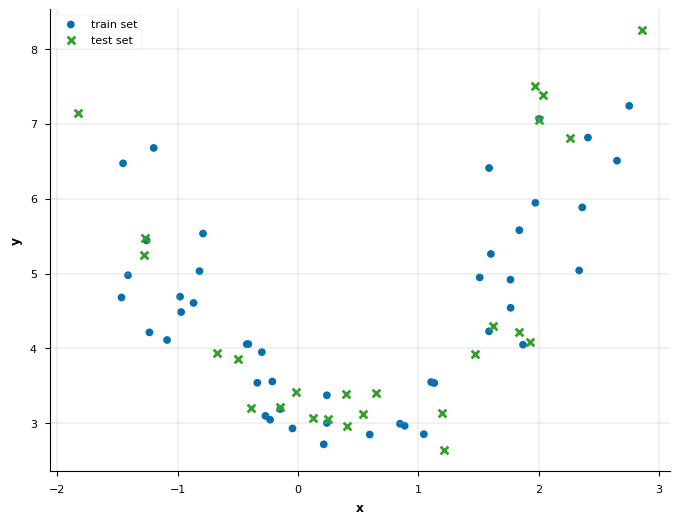

In [23]:
np.random.seed(240)
n_samples = 70
x = np.random.uniform(-2, 2.5, n_samples)  
y = 0.1*x**3+x**2 - x + 3   # computing the outputs

output_noise = np.random.randn(n_samples) * 0.1
y += output_noise  # adding some output noise

input_noise = np.random.randn(n_samples) * 0.3
x += input_noise  # adding some input noise


n_test = 25
all_ids = np.linspace(0,n_samples-1,n_samples).astype(int)
test_set_ids = np.random.choice(all_ids, size=n_test, replace=False)

x_test = x[test_set_ids] 
y_test = y[test_set_ids]

train_set_ids = [ii for ii in all_ids if ii not in test_set_ids]

x_train = x[train_set_ids]
y_train = y[train_set_ids]

fig, ax = plt.subplots()
ax.scatter(x_train, y_train,label='train set')
ax.scatter(x_test, y_test, label='test set',marker='x')
ax.set(
    xlabel='x', 
    ylabel='y');
ax.legend();

Now we have the basic idea of polynomial regression and some noisy data, let's begin! The key difference between fitting a linear regression model and a polynomial regression model lies in how we structure the input variables.  

For the very first simple linear regression, we used $\mathbf{X} = \mathbf{x}$ as the input data, where $\mathbf{x}$ is a vector and each element is the input for a single data point. To add a constant bias (a y-intercept in a 2-D plot), we used $\mathbf{X} = \big[ \boldsymbol 1, \mathbf{x} \big]$, where $\boldsymbol 1$ is a column of ones in the second example.  When fitting, we learned a weight for each column of this matrix and therefore gained the bias ($\theta_0$) in addititon to $\theta_1$. 

This matrix $\mathbf{X}$ that we use for our inputs is known as a **design matrix**. We want to create our design matrix so we learn weights for $\mathbf{x}^2, \mathbf{x}^3,$ etc. Thus, we want to build our design matrix $X$ for polynomial regression of order $k$ as:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}^1, \mathbf{x}^2 , \ldots , \mathbf{x}^k \big],
\end{equation}

where $\boldsymbol{1}$ is the vector the same length as $\mathbf{x}$ consisting of of all ones, and $\mathbf{x}^p$ is the vector $\mathbf{x}$ with all elements raised to the power $p$. Note that $\boldsymbol{1} = \mathbf{x}^0$ and $\mathbf{x}^1 = \mathbf{x}$.  

If we have inputs with more than one feature, we can use a similar design matrix but include all features raised to each power. Imagine that we have two features per data point: $\mathbf{x}_m$ is a vector of one feature per data point and  $\mathbf{x}_n$ is another.  Our design matrix for a polynomial regression would be:

\begin{equation}
\mathbf{X} = \big[ \boldsymbol 1 , \mathbf{x}_m^1, \mathbf{x}_n^1, \mathbf{x}_m^2 , \mathbf{x}_n^2\ldots , \mathbf{x}_m^k , \mathbf{x}_n^k \big],
\end{equation}

Below we create the design matrix for different orders of polynomial functions

In [26]:
def make_design_matrix(x, order):
    # Broadcast to shape (n x 1) so dimensions work
    if x.ndim == 1:
        x = x[:, None]
        
    design_matrix = np.ones((x.shape[0], 1))

    # Loop through rest of degrees and stack columns
    for degree in range(1, order + 1):
        design_matrix = np.hstack((design_matrix, x**degree))

    return design_matrix

Now that we have the inputs structured correctly in our design matrix, fitting a polynomial regression is the same as fitting a linear regression model! All of the polynomial structure we need to learn is contained in how the inputs are structured in the design matrix. We can use the same least squares solution we computed in previous exercises. 

below we implement this solution. Have a look at the different fits. Which one describes the data best?

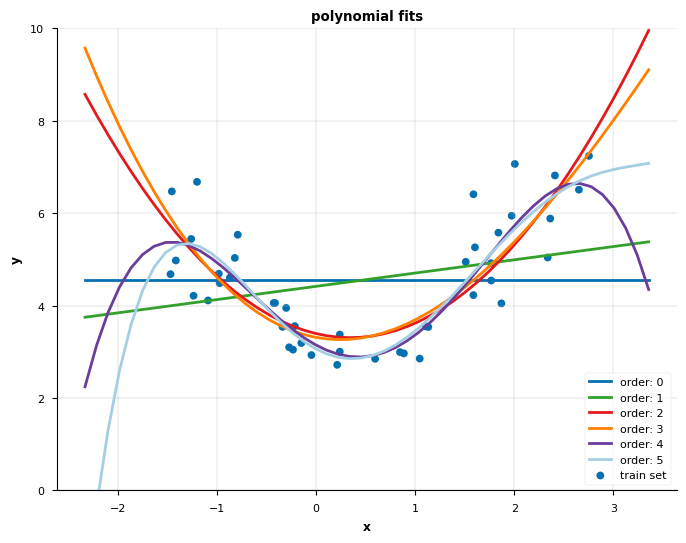

In [27]:
def solve_poly_reg(x, y, max_order):
    # Create a dictionary with polynomial order as keys,
    # and np array of theta_hat (weights) as the values
    theta_stars = {}

    # Loop over polynomial orders from 0 through max_order
    for order in range(max_order + 1):

        # Create design matrix
        X_design = make_design_matrix(x, order)

        # Fit polynomial model
        this_theta = solve_normal_eqn(X_design, y[:,None])

        theta_stars[order] = this_theta

    return theta_stars


list_of_orders = [0,1,2,3,4,5]
theta_stars = solve_poly_reg(x_train, y_train, np.max(list_of_orders))


x_grid = np.linspace(x.min() - .5, x.max() + .5)
fig, ax = plt.subplots()

for order in list_of_orders:
    X_design = make_design_matrix(x_grid, order)
    ax.plot(x_grid, X_design @ theta_stars[order], label=f'order: {order}');

ax.set(
    xlabel ='x',
    ylabel = 'y',
    title = 'polynomial fits',
    ylim = [0,10]
)
ax.scatter(x_train, y_train,label='train set')

ax.legend()


We now want to evaluate how well the models capture the data. We can again compute the mean squared error (MSE) for every model

We compute MSE as:

\begin{equation}
\mathrm{MSE} = \frac 1 N ||\mathbf{y} - \mathbf{y}^*||^2 = \frac 1 N \sum_{i=1}^N (y_i -  y_i^*)^2 
\end{equation}

where the predicted values for each model are given by $\mathbf{y}^* = \mathbf{X}\boldsymbol{\theta}^*$.

Now we can do this for both, the _train_set_ that we used to train the model, and with the _test_set_ that we hold back and that was not part of the training procedure 

*Which model (i.e. which polynomial order) do you think will have the best MSE for the test set, which one will have the best for the train set?*

[Text(0.5, 0, 'Order of polynomal fit'), Text(0, 0.5, 'MSE')]

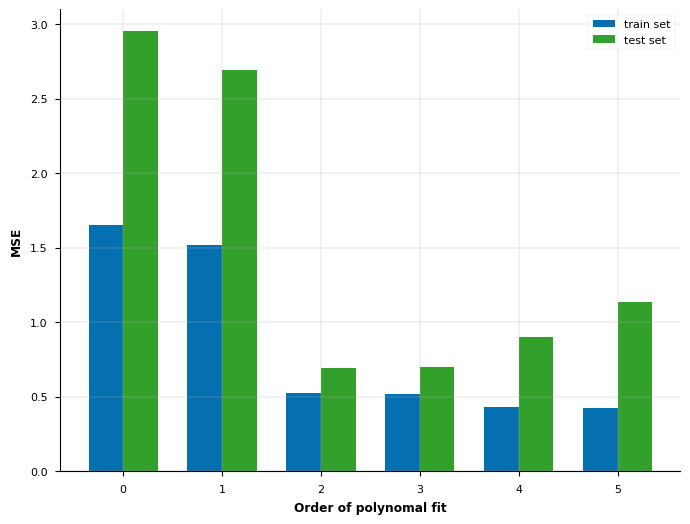

In [28]:
mse_list_test = []
mse_list_train = []


for order in list_of_orders:

    X_design_train = make_design_matrix(x_train, order)
    X_design_test = make_design_matrix(x_test, order)

    # Get prediction for the polynomial regression model of this order
    y_star_train = X_design_train @ theta_stars[order]
    y_star_test = X_design_test @ theta_stars[order]
    
    # Compute the residuals
    residuals_train = y_train - y_star_train
    
    
    residuals_test = y_test - y_star_test

    # Compute the MSE
    mse = np.mean(residuals_train ** 2)
    mse_list_train.append(mse)
    
    mse = np.mean(residuals_test ** 2)
    mse_list_test.append(mse)



fig, ax = plt.subplots()
width = .35

ax.bar(np.array(list_of_orders) - width / 2, mse_list_train, width, label="train set")
ax.bar(np.array(list_of_orders) + width / 2, mse_list_test , width, label="test set")
ax.legend()
ax.set(
    xlabel = 'Order of polynomal fit',
    ylabel = 'MSE',)

We see that the MSE on the train set gets smaller, the more paramter we use. 
However the MSE on the test sets first gets smaller but then increases again. 

This is an example of the bias-variance trade-off.

A model with few parameters has a high bias: In our example, we put in a very strong assumption into the model with only one parameter, namely that y is independent of x. This is not the case, therefore the training error is high. 

The more paramter we include, the better the model can be fit to the data, or in other words, the better it can capture the variance of the data. 
However, this can lead to over-fitting as we can see for the models with many parameters. Capturing to much of the variance of the data therefore prevents the model from making good predictions about future data. 

This is summarized in the following figure (taken from [here](http://scott.fortmann-roe.com/docs/BiasVariance.html))
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_11/static/biasvariance.png" width="550"/>
</div>

If you want to learn more about confidence intervals, bootstrapping, and cross-validation, you can check out the following notebooks from the [neuromatch academy](https://compneuro.neuromatch.io/tutorials/intro.html) (and also all the other notebooks they provide), they also functioned as inspiration for some plots in this notebook.

The relevant notebooks are

[bootstrapping and confidence intervals](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial3.ipynb)
[Model Selection: Bias-variance trade-off](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial5.ipynb)
[Model Selection: Cross-validation](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial6.ipynb)


# GLMs 

Generalized linear models are a very flexible class of models with many applications. 
In this short exercise we look at a Poisson GLM that is able to identify the linear filter of a 2D stimulus, the receptive field of a neuron. 
As a reminder, here are the GLMs that have been discussed in the lecture:


<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_11/static/glm_overview.png" width="950"/>
</div>


### Generate a model

To fit the GLM, we first need the data. 
The function _show_visual_space_ is used to visualize the input patterns and the filter that we use (or find)

_gaussian_2d_ can generate a simple 2d gaussian, that we use for the filter.

The _generator_model_ then takes the images we provide and generates spikes


In [29]:
def show_visual_space(pattern, ax = None, style='filter',alpha=1):
    
    if ax == None:
        fig, ax = plt.subplots()
    
    if style == 'filter':
        max_ = np.max(np.abs(pattern))
        print (max_)
        ax.imshow(pattern,cmap='bwr', alpha=alpha, vmin = -max_, vmax=max_)
    else:
        ax.imshow(pattern,cmap='binary', alpha=alpha)
    ax.grid(False)
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    right=False,         # ticks along the righ edge are off
    labelleft=False) # labels along the left edge are off

In [30]:
def gaussian_2d(size, mu_x, mu_y, sig_x,sig_y):
    """ 
    Make an eliptic gaussian kernel in a square.

    size is the length of a side of the square
    mu_x and mu_y are the mean values of x and y
    sig_x and sig_y define the spread of the guassian
    """

    x = np.arange(0, size, 1, float)      
    y = x[:,np.newaxis]

    return np.exp(-4*np.log(2) * (((x-mu_x)/sig_x)**2 + ((y-mu_y)/ sig_y)**2))

0.892393847513135


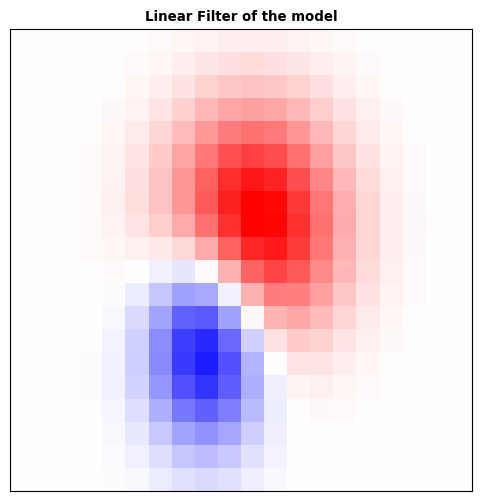

In [40]:
def generator_model(input_pattern, size = 20, ax=None):
    
    
    
    def poisson(y,lam):
        return (lam)**y/special.factorial(y) * np.exp(-lam)
    
    
    
    pos = gaussian_2d(size=size, mu_x=10, mu_y=8, sig_x = 6,sig_y = 8)
    neg = gaussian_2d(size=size, mu_x=8, mu_y=13, sig_x = 4,sig_y = 7)
    filter_matrix = pos-neg

    if ax != None:
        show_visual_space(filter_matrix, ax = ax, style='filter',alpha=1)

        
    dim_red = np.sum(input_pattern * filter_matrix)


    y = np.linspace(0,80,81).astype(int)
    prob = np.cumsum(poisson(lam=np.exp(dim_red),y = y))
    threshold = np.random.rand()
    n_spikes = np.argmax(prob>threshold)
    
    return n_spikes

fig, ax = plt.subplots()
generator_model(input_pattern=0, size = 20, ax=ax)
ax.set(title='Linear Filter of the model');

    



### Generate sample images

We use the function _create_random_image_ to gerate the sample data, that we can feed into our generator model to generate the spike outputs.


In [32]:
def create_random_image(size=20):
    
    random_dots = np.random.rand(size,size)*1
    random_dots[np.random.rand(size,size)<0.92] = 0
    
    return random_dots

def get_random_gaussian_stim(size=20):
    
    mu_x = np.random.rand()*size
    mu_y = np.random.rand()*size
    
    sig_x = (0.5+np.random.rand())*6
    sig_y = (0.5+np.random.rand())*6
    
    pattern = gaussian_2d(size=size, mu_x=mu_x, mu_y=mu_y, sig_x = sig_x,sig_y = sig_y)
    scaled_pattern = pattern * 0.2
    return scaled_pattern

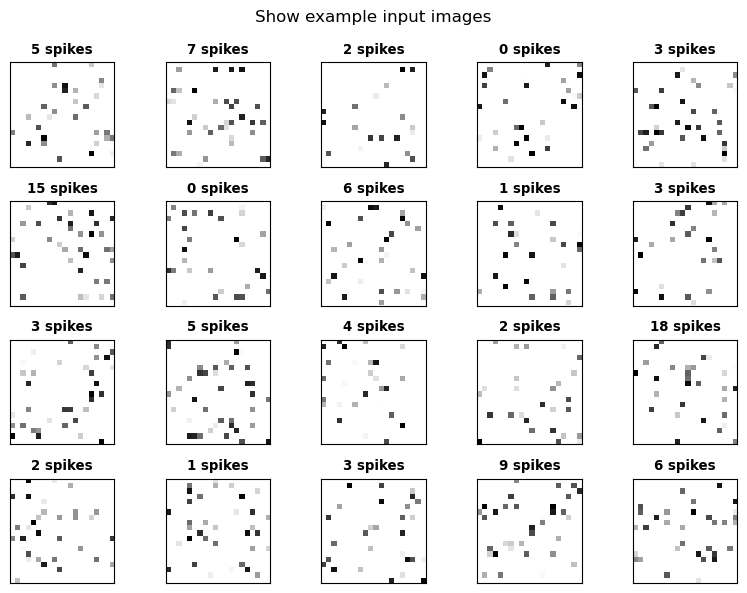

In [33]:
def get_input_image(size=20):
    
    return create_random_image(size=size)
#     return get_random_gaussian_stim(size=20)


size=20

np.random.seed(14)
fig, axes = plt.subplots(4,5) 
axes_flat = axes.flatten()
for ii in range(20):
    
    image = get_input_image(size=size)
    spikes = generator_model(image, size=size)
    
    show_visual_space(image, style='random',ax=axes_flat[ii])
    axes_flat[ii].set_title(f'{spikes} spikes')

fig.suptitle('Show example input images')
fig.tight_layout()

    


We can now use these random images and the generated response to try to fit the Poisson GLM (linear-nonlinear-poisson) to the data. 

First we define the negative log-likelihood (by doing this we search for the minimum an not the maximum) 

We then use the scipy module *from scipy.optimize import minimize* to find the minimum (i.e. the best theta)

(2001, 1) (2001, 400)
1.0066486255376945


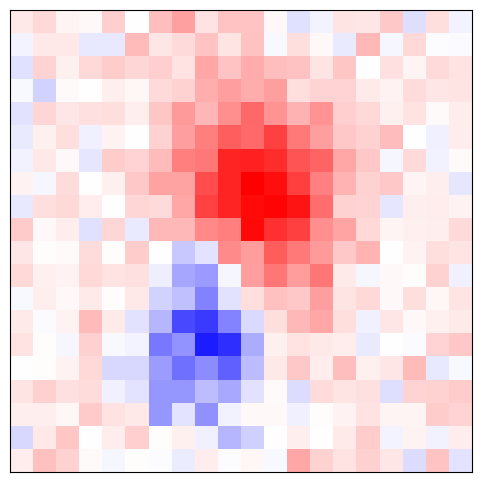

In [34]:
def neg_log_lik_lnp(theta, X, y):
    """Return -loglike for the Poisson GLM model.
    Args:
        theta (1D array): Parameter vector.
        X (2D array): Full design matrix.
        y (1D array): Data values.
    Returns:
        number: Negative log likelihood.
    """
    # Compute the Poisson log likelihood
    rate = np.exp(X @ theta)
    log_lik = y.T @ np.log(rate) - rate.sum()
    return -log_lik


def fit_lnp(stim, spikes):
    """Obtain MLE parameters for the Poisson GLM.
    Args:
        stim (1D array): Stimulus values at each timepoint
        spikes (1D array): Spike counts measured at each timepoint
        d (number): Number of time lags to use.
    Returns:
        1D array: MLE parameters
    """

    # Build the design matrix
    y = spikes
    constant = np.ones_like(y)
    
    print (constant.shape, stim.shape)
    X = np.hstack([constant, stim])

    # Use a random vector of weights to start (mean 0, sd .2)
    x0 = np.random.normal(0, .2, X.shape[1])

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_lik_lnp, x0, args=(X, y))

    return res["x"]


# Fit LNP model

np.random.seed(100)


for ii in range(2000):
    
    image = get_input_image()
    spikes = generator_model(image)
    
    if ii == 0:
        stim = np.array(image.flatten())
        all_spikes = np.array(spikes)
    
    
    
    stim = np.vstack([stim,image.flatten()])
    all_spikes = np.vstack([all_spikes,spikes])




theta_lnp = fit_lnp(stim, all_spikes)
show_visual_space(theta_lnp[0]+theta_lnp[1:].reshape((20,20)), style='filter')




### Further reading/exercises

If you want to learn more about GLMs, you can check out the neuromatch tutorials:

In case you want to try fitting a GLM to 1D temporal data:
[GLMs for Encoding](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.ipynb)

If you want to learn more about how to avoid over-fitting with GLMs (how to introduce a stronger bias):
[Classifiers and regularizers](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial2.html)
    
    
    